# Proyecto de la materia Procesamiento Embebido de Señales
## Segmentación de imágenes con OpenCV y SciKit-image
### Métodos de sementación de imágenes

![alt text](metodos_segmentacion.png "Metodos Segmentación")

El presente trabajo práctico tiene como objetivo la segmentación **no supervisada** de imagenes.

Para ello se cuentan con las siguientes etapas:
1. Preprocesamiento de la imagen
2. Visualización del histograma de la imagen (en RGB)
3. Algoritmo K-Means (OpenCV)
4. Algoritmo SLIC (Simple Linear Iterative Clustering)
    1. RAG con corte por umbral
    2. RAG con corte normalizado
5. Algoritmo Felzenszwalb
    1. RAG con corte por umbral
    2. RAG con corte normalizado
6. Contadores de segmentos únicos segun cada algoritmo con su variante
7. Histograma de gradientes orientados
8. Etiquetado de contornos en base a segmentación realizada (Labeling)

Finalmente se comparará el algoritmo con una imagen ruidosa:
1. Agregación de ruido a la imagen original

Pendientes a implementar:
1. RAG Merging
2. Hierarchical Merging of Region Boundary RAGs
3. Drawing Region Adjacency Graphs (RAGs)
4. Morphological Snakes
5. Entropía



### Algoritmo K-Means
Se caracteriza por buscar los centros de una cierta cantidad de clusters y agrupa las muestras de entrada en dichos clusters.

### Algoritmo SLIC (Simple Linear Iterative Clustering)
Se caracteriza por utilizar otro algoritmo de machine-learning denominado K-Means.
El mismo toma todos los valores de los pixeles de la imagen e intenta separarlos en una determinada cantidad de sub-regiones.
Toma la imagen a color (3 canales) por lo que se usará la imagen original

### Algoritmo Felzenszwalb


Nota: al método utilizado para segmentar se lo conoce como "over-segmentation" ya que corresponde a una primera aproximación de segmentación en un algoritmo real.

### RAG Thresholding
La técnica Region Adjacency Graph (RAG) realiza un merge de las regiones que tienen colores similares. Se construirá un RAG y se definirán bordes como la diferencia del promedio de colores. Luego se unirán las regiones que contengan un promedio de color similar (dependiendo el umbral de threshold).

## Fotos testeadas y funcionando
- 94079.jpg
- 56028.jpg
- 314016.jpg

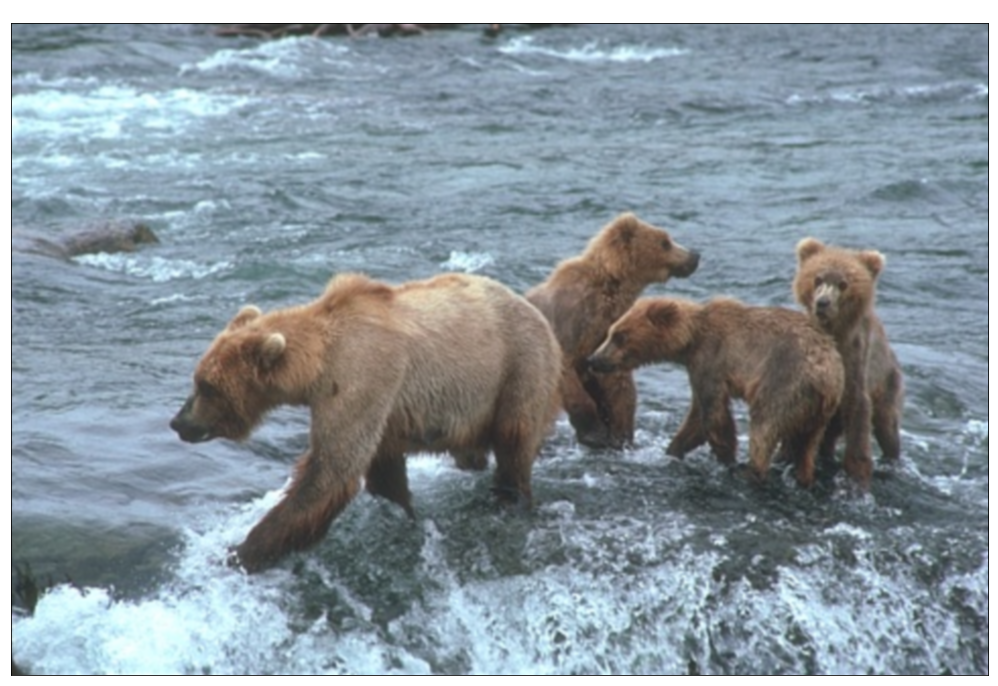

In [163]:
from __future__ import division
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import imutils
import skimage.data as data
import skimage.exposure as exposure
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.feature as feature
import skimage.morphology as morph
import skimage.util as util
import skimage.future as future

def nothing(x):
    pass

# parametros de ajuste
invertir_threshold = True
umbral = 100
kernel_apertura = (3,3)
iter_apertura = 4
kernel_cierre = (3,3)
iter_cierre = 5

# Importar imagen del dataset
ruta_img = 'imagenes/94079.jpg'
imagen = cv2.imread(ruta_img,1)
# Se transforma la imagen BRG a HSV
imagen = cv2.cvtColor(imagen, cv2.cv.CV_BGR2HSV)


fig = plt.figure(figsize=(18,12))
plt.title("Imagen: {}".format(ruta_img.split('/')[-1]),color="white")
plt.xticks([]),plt.yticks([])
# Se grafica la imagen con MATPLOTLIB
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_HSV2RGB)
plt.imshow(imagen_rgb, interpolation = 'bicubic')

plt.show()

### Agregación de ruido a la imagen

Text(0.5,1,'Imagen 94079.jpg con el ruido agregado')

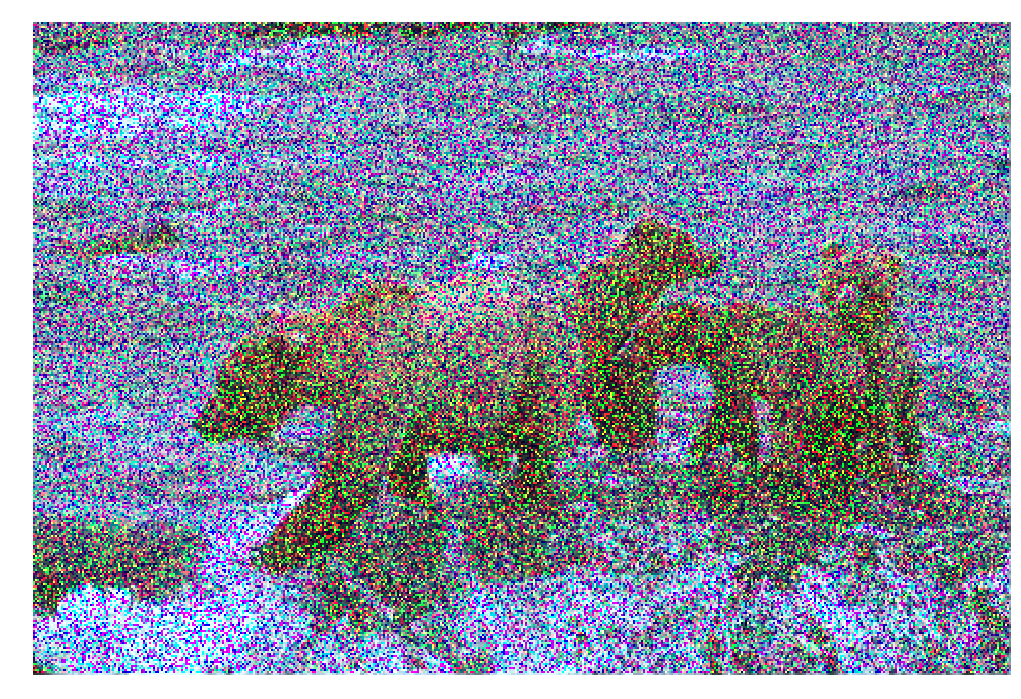

In [164]:
img_ruidosa_rgb = np.copy(imagen_rgb)
coords = [np.random.randint(0, i - 1, 100000)
              for i in imagen.shape]
img_ruidosa_rgb[tuple(coords)] = 255
coords = [np.random.randint(0, i - 1, 100000)
              for i in imagen.shape]
img_ruidosa_rgb[tuple(coords)] = 0
#img_ruidosa_rgb = cv2.cvtColor(img_ruidosa, cv2.COLOR_HSV2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(img_ruidosa_rgb)
plt.axis('off')
plt.title('Imagen {} con el ruido agregado'.format(ruta_img.split('/')[-1]),
          color="white")


Text(0.5,1,'Imagen 94079.jpg con el ruido subsanado')

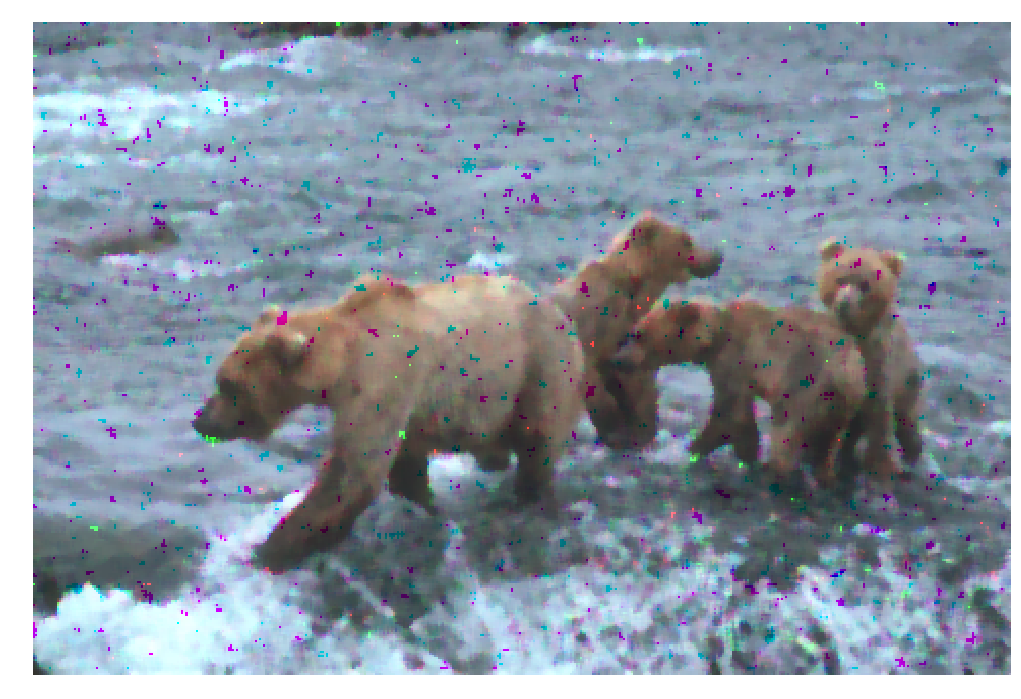

In [165]:
mediana = cv2.medianBlur(img_ruidosa_rgb,5)
fig = plt.figure(figsize=(18,12))
plt.imshow(mediana)
plt.axis('off')
plt.title('Imagen {} con el ruido subsanado'.format(ruta_img.split('/')[-1]),
          color="white")


### Preprocesamiento de la imagen

Text(0.5,1,'Imagen 94079.jpg filtrada por mediana')

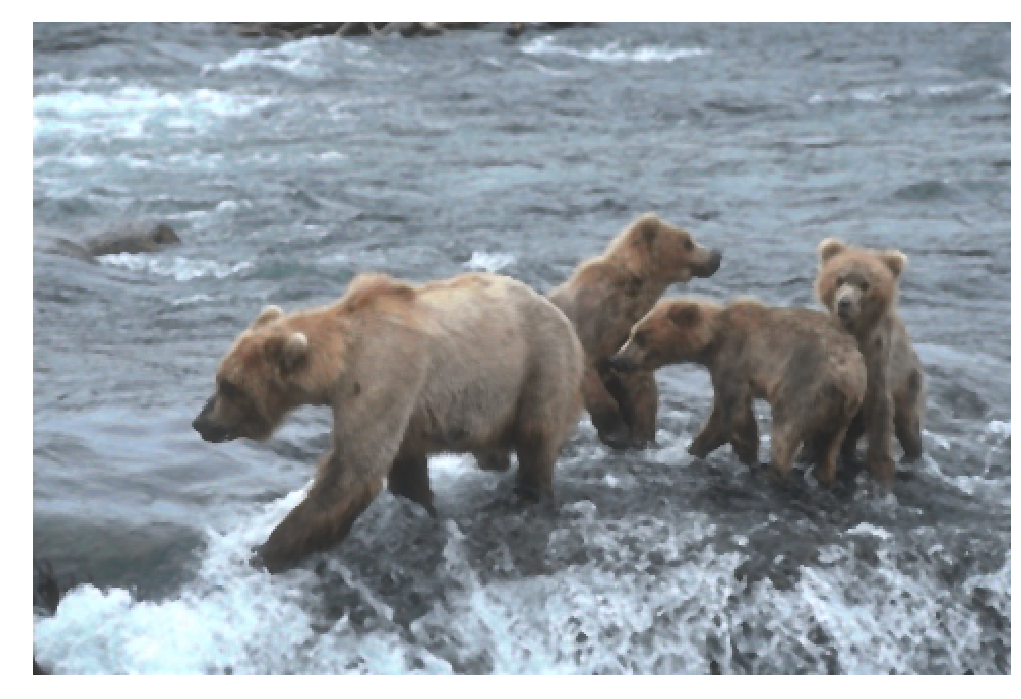

In [166]:
# Se aplica un filtro de mediana con kernel de tamaño 3
mediana_filtrada = scipy.ndimage.median_filter(imagen_rgb, size=3)
fig = plt.figure(figsize=(18,12))
plt.imshow(mediana_filtrada)
plt.axis('off')
plt.title('Imagen {} filtrada por mediana'.format(ruta_img.split('/')[-1]),
          color="white")

Text(0,0.5,'Cantidad')

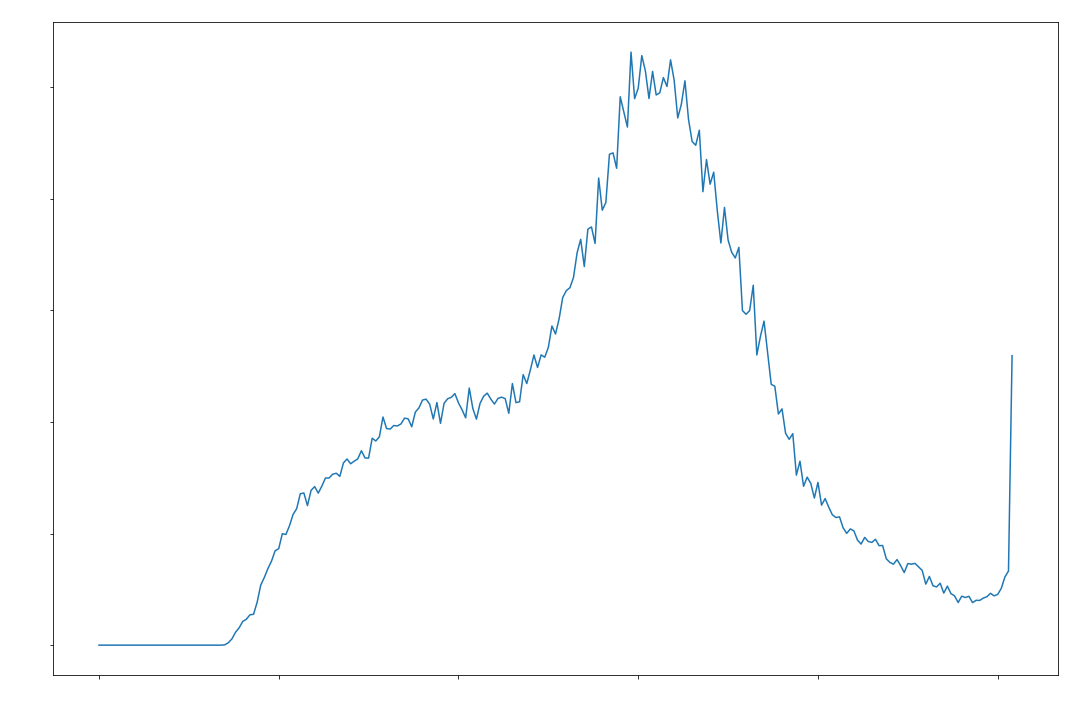

In [167]:
cant, valores = np.histogram(mediana_filtrada, bins=range(2 ** 8))
fig = plt.figure(figsize=(18,12))

plt.plot(range(0, (2 ** 8) - 1), cant)
plt.xticks(color="white"),plt.yticks(color="white")
plt.title('Histograma de la imagen en RGB',color="white")
plt.xlabel('Intensidad de pixel',color="white")
plt.ylabel('Cantidad',color="white")

### K-Means (OpenCV)

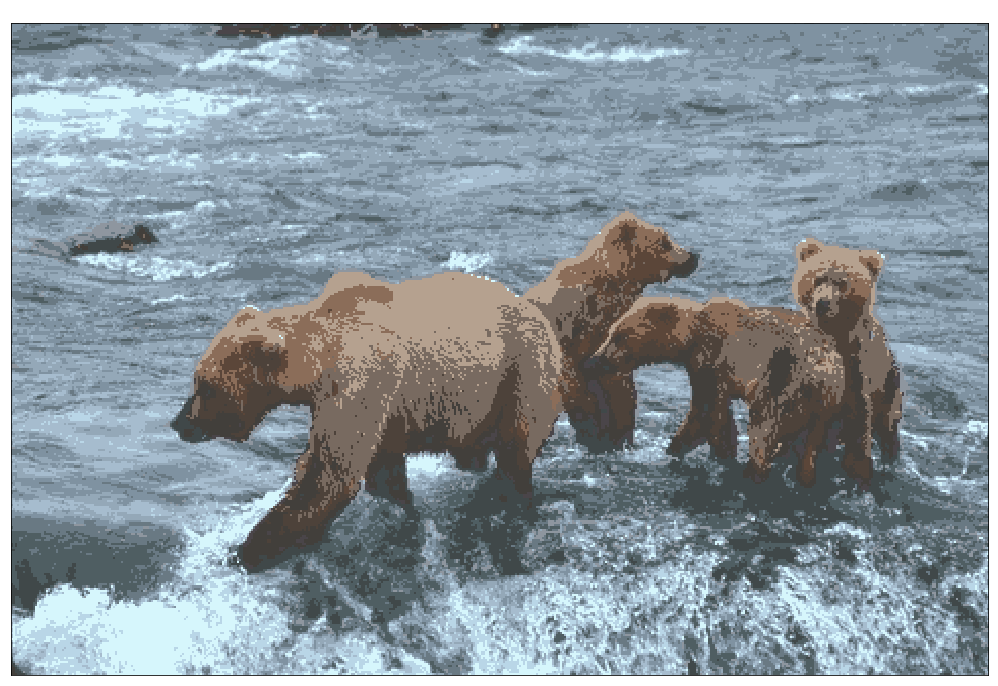

In [192]:
Z = imagen.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 16

ret,segmentos_kmeans,center = cv2.kmeans(Z, K, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[segmentos_kmeans.flatten()]
res2 = res.reshape((imagen.shape))

res2_rgb = cv2.cvtColor(res2,cv2.COLOR_HSV2RGB)
fig = plt.figure(figsize=(18,12))
plt.imshow(res2_rgb)
plt.title('Algoritmo K-Means (OpenCV) de la imagen', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


### Algoritmo SLIC (Simple Linear Iterative Clustering)

Text(0.5,1,'Algoritmo SLIC')

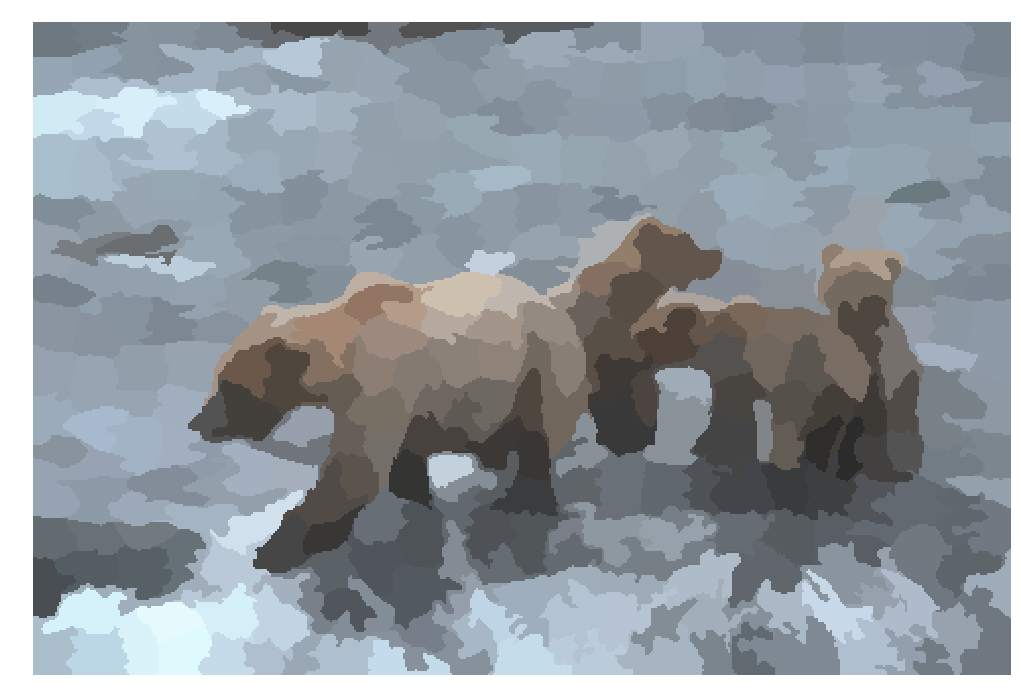

In [169]:
segmentos_slic = seg.slic(mediana_filtrada,n_segments=400, compactness=10, sigma=1)
######## CON 155 segmentos el RAG QUEDABA MAL, con 400 quedo casi impecable

# label2rgb replaces each discrete label with the average interior color
fig = plt.figure(figsize=(18,12))
plt.imshow(color.label2rgb(segmentos_slic, mediana_filtrada, kind='avg'))
plt.axis('off')
plt.title('Algoritmo SLIC', color='white')

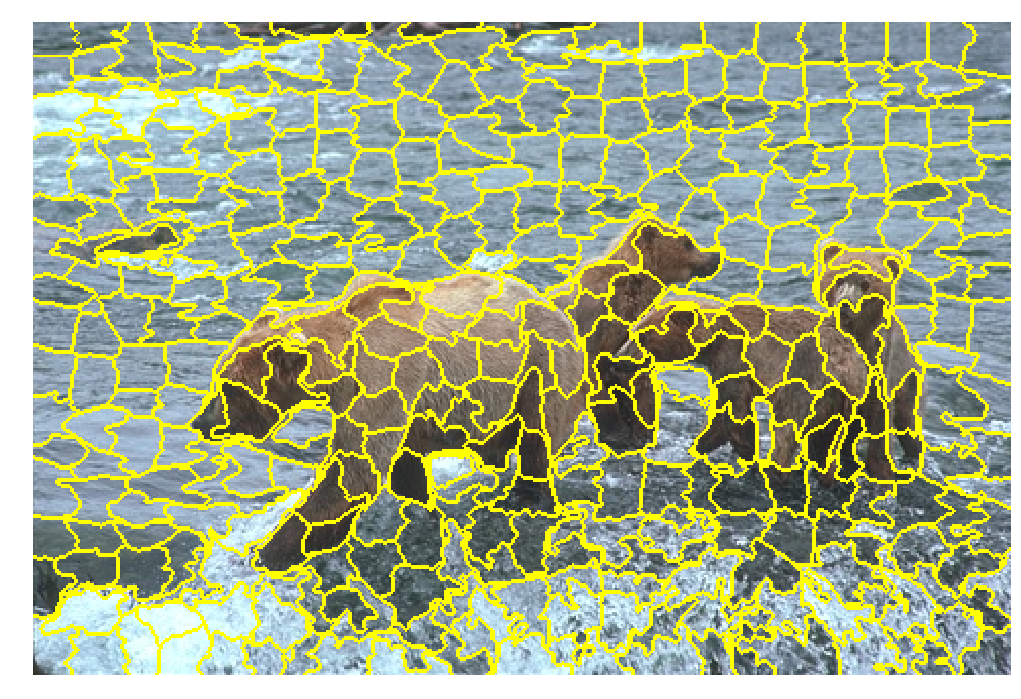

In [186]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_slic))
plt.axis('off')
plt.title('Contornos para Algoritmo Slic', color='white')
plt.show()

### RAG para SLIC con corte por umbral (cut threshold)

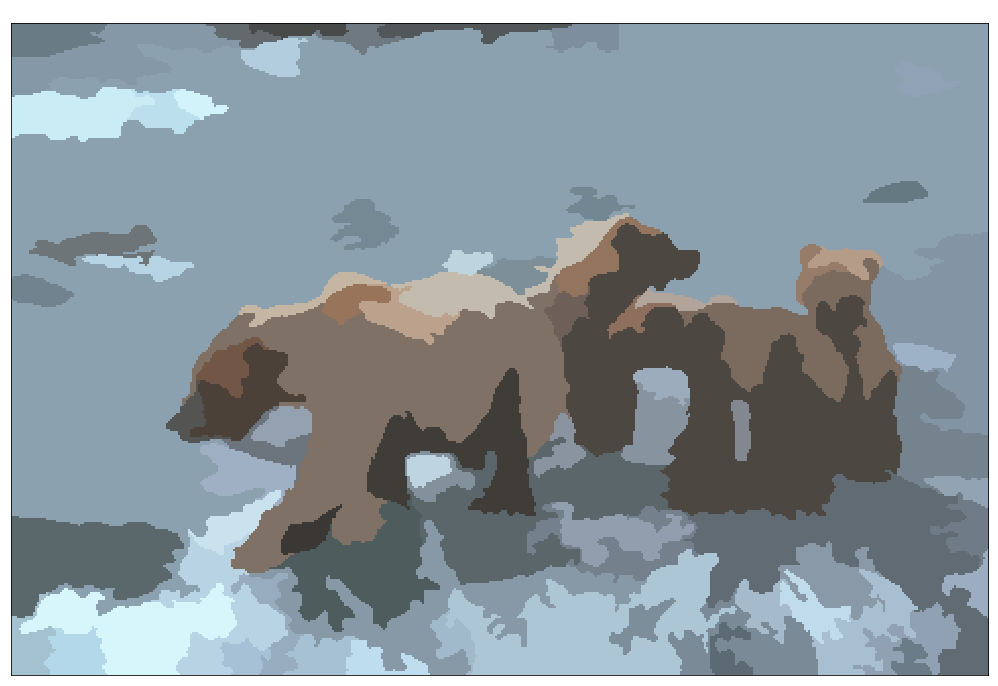

In [171]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic)
segmentos_rag_slic = future.graph.cut_threshold(segmentos_slic, g, 29)
out2 = color.label2rgb(segmentos_rag_slic, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo SLIC con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


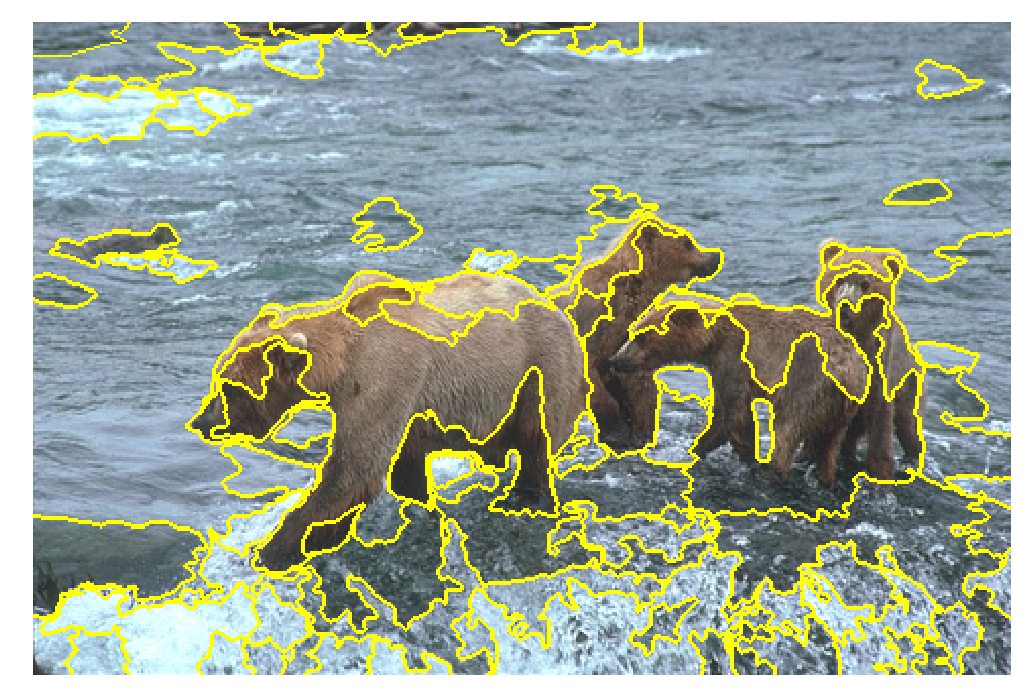

In [172]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic))
plt.axis('off')
plt.title('Contornos RAG para Slic con corte por umbral', color='white')
plt.show()

### RAG para SLIC con corte normalizado (normalized cut)

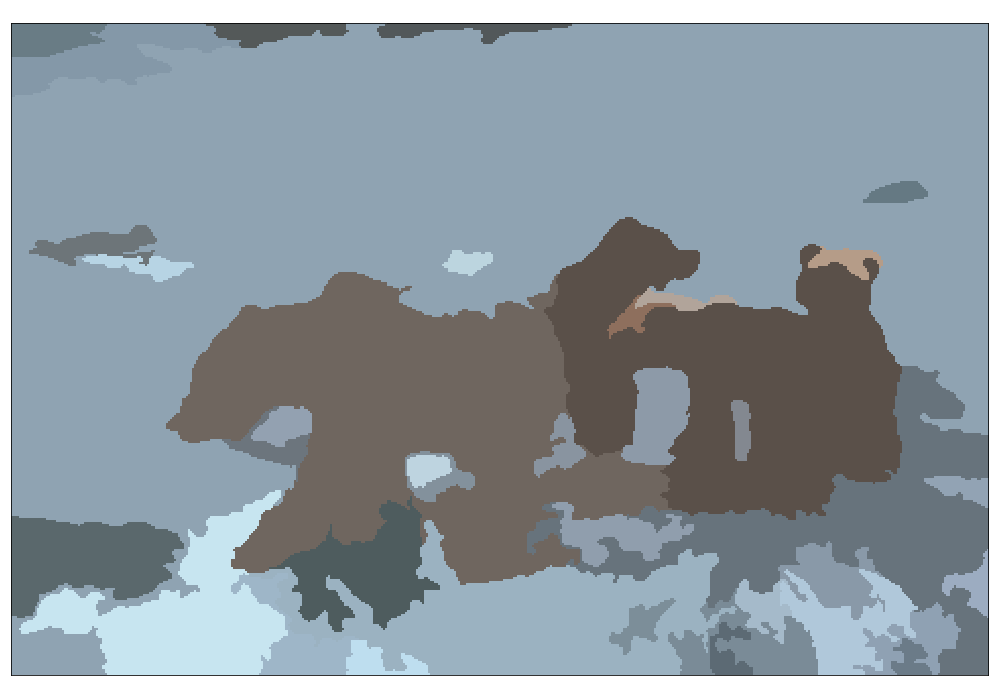

In [173]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_slic, mode='similarity')
segmentos_rag_slic_normalizado = future.graph.cut_normalized(segmentos_slic, g)
out2 = color.label2rgb(segmentos_rag_slic_normalizado, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo SLIC por corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()


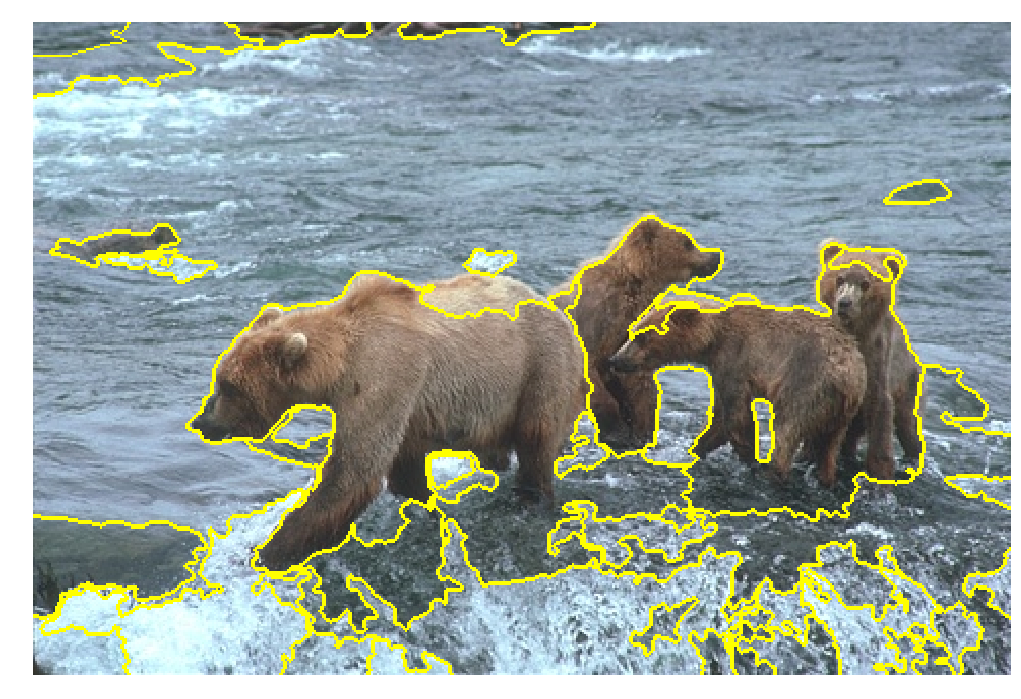

In [174]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_slic_normalizado))
plt.axis('off')
plt.title('Contornos RAG para Slic con corte normalizado', color='white')
plt.show()

### Algoritmo Felzenszwalb

Text(0.5,1,'Algoritmo Felzenszwalb')

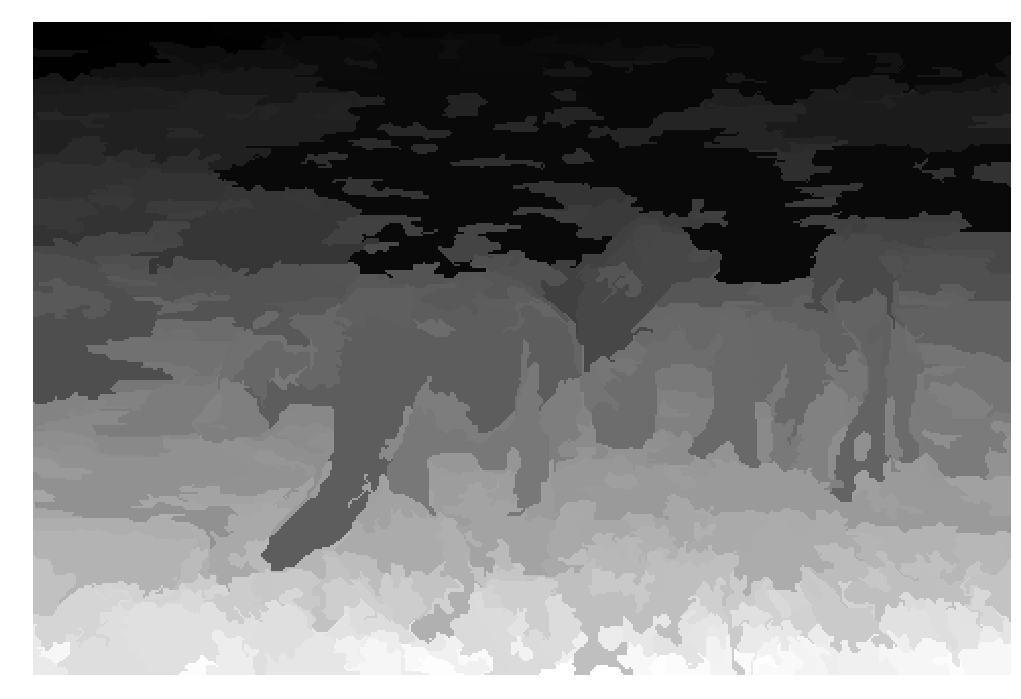

In [175]:
segmentos_felzenszwalb = seg.felzenszwalb(mediana_filtrada, scale=100, sigma=0.5, min_size=50) 
fig = plt.figure(figsize=(18,12))
plt.imshow(segmentos_felzenszwalb, cmap='gray')
plt.axis('off')
plt.title('Algoritmo Felzenszwalb', color='white')

Text(0.5,1,'Imagen Felzenszwalb Coloreada')

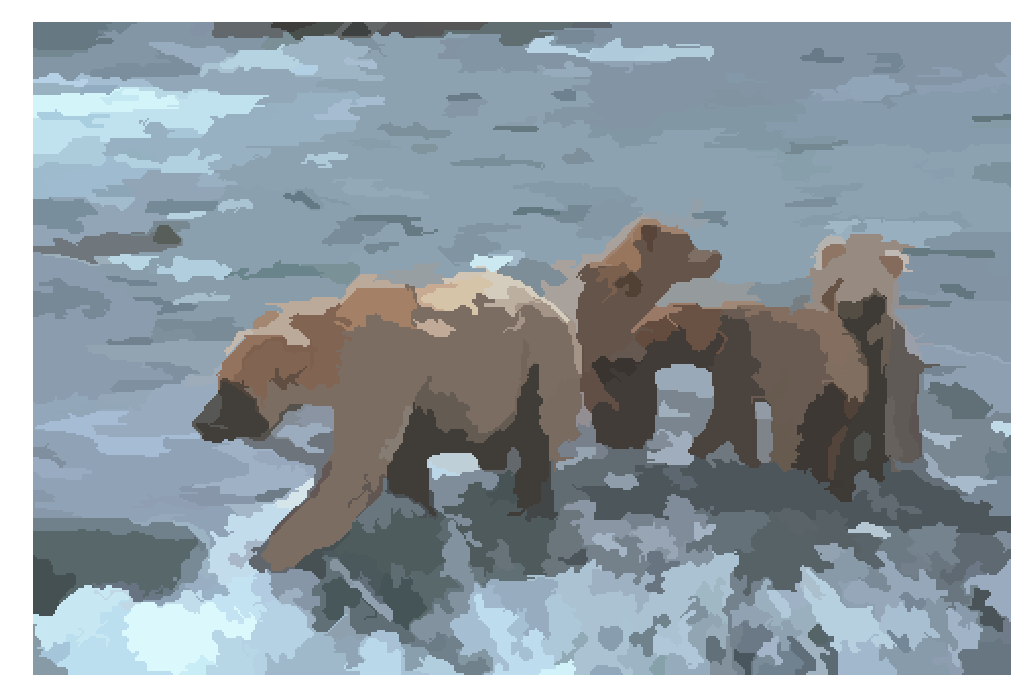

In [176]:
imagen_felzenszwalb_coloreada = color.label2rgb(segmentos_felzenszwalb, imagen_rgb, kind='avg')
fig = plt.figure(figsize=(18,12))
plt.imshow(imagen_felzenszwalb_coloreada)
plt.axis('off')
plt.title('Imagen Felzenszwalb Coloreada', color='white')

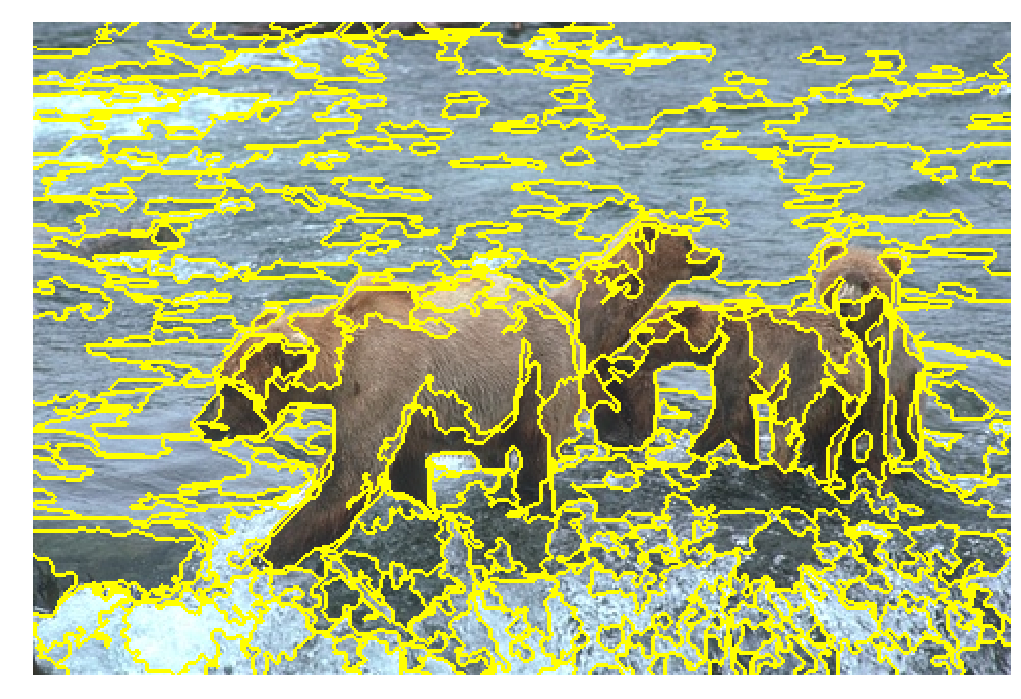

In [220]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_felzenszwalb,
                               color=(1, 1, 0), outline_color=None,
                               mode='outer', background_label=0))
plt.axis('off')
plt.title('Contornos para Algoritmo Felzenszwalb', color='white')

plt.show()

### RAG para Falzenszwalb con corte por umbral

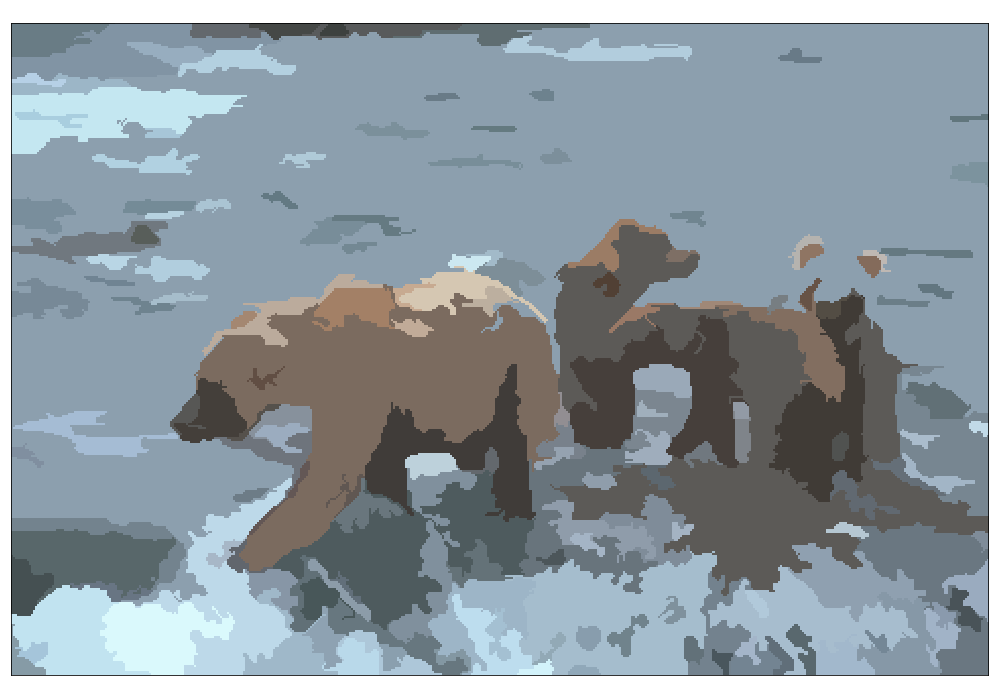

In [178]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb)
segmentos_rag_felzenszwalb = future.graph.cut_threshold(segmentos_felzenszwalb, g, 29)
out2 = color.label2rgb(segmentos_rag_felzenszwalb, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo Felzenszwalb con corte por umbral', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

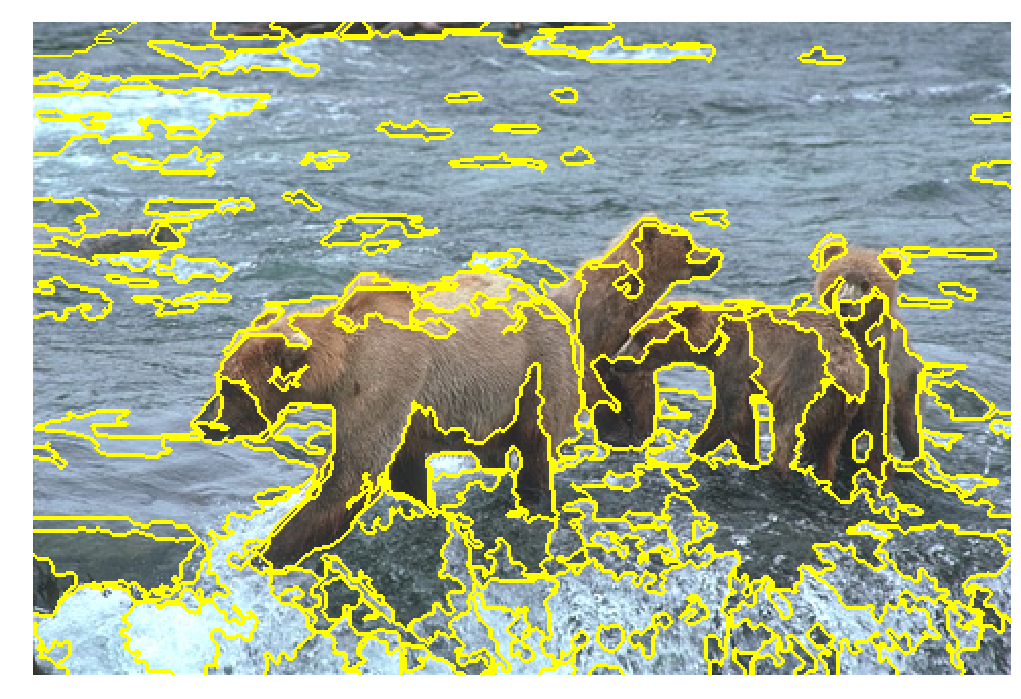

In [188]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb))
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con corte por umbral', color='white')
plt.show()

### RAG para Felzenszwalb con corte normalizado

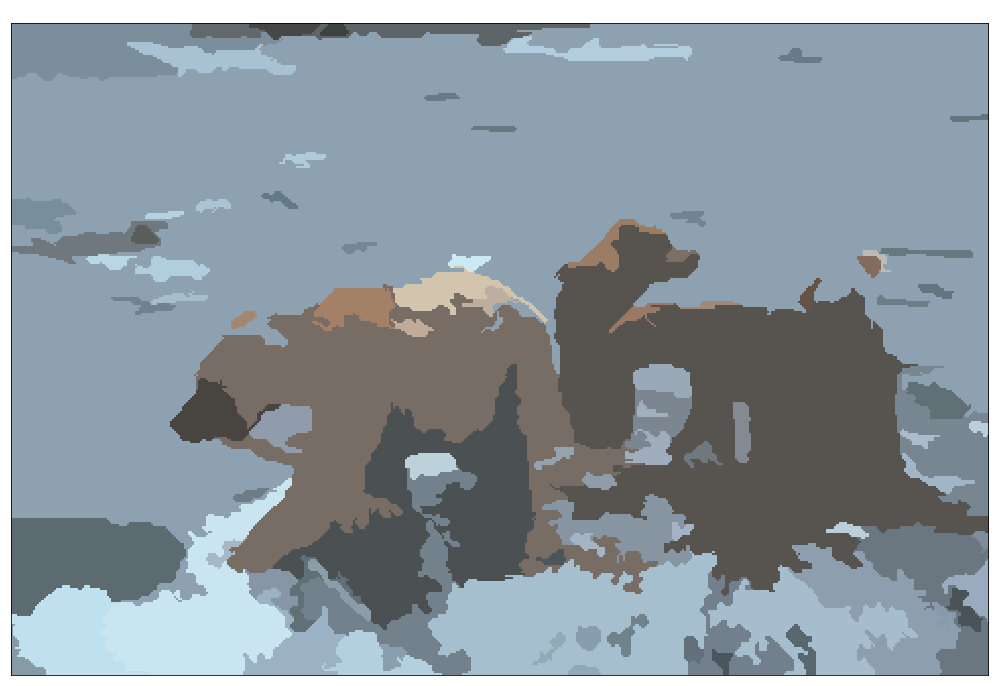

In [180]:
g = future.graph.rag_mean_color(imagen_rgb, segmentos_felzenszwalb, mode='similarity')
segmentos_rag_felzenszwalb_normalizado = future.graph.cut_normalized(segmentos_felzenszwalb, g)
out2 = color.label2rgb(segmentos_rag_felzenszwalb_normalizado, imagen_rgb, kind='avg')

fig = plt.figure(figsize=(18,12))
plt.imshow(out2)
plt.title('RAG para Algoritmo Felzenszwalb con corte normalizado', color="white")
plt.xticks([]),plt.yticks([])
plt.show()

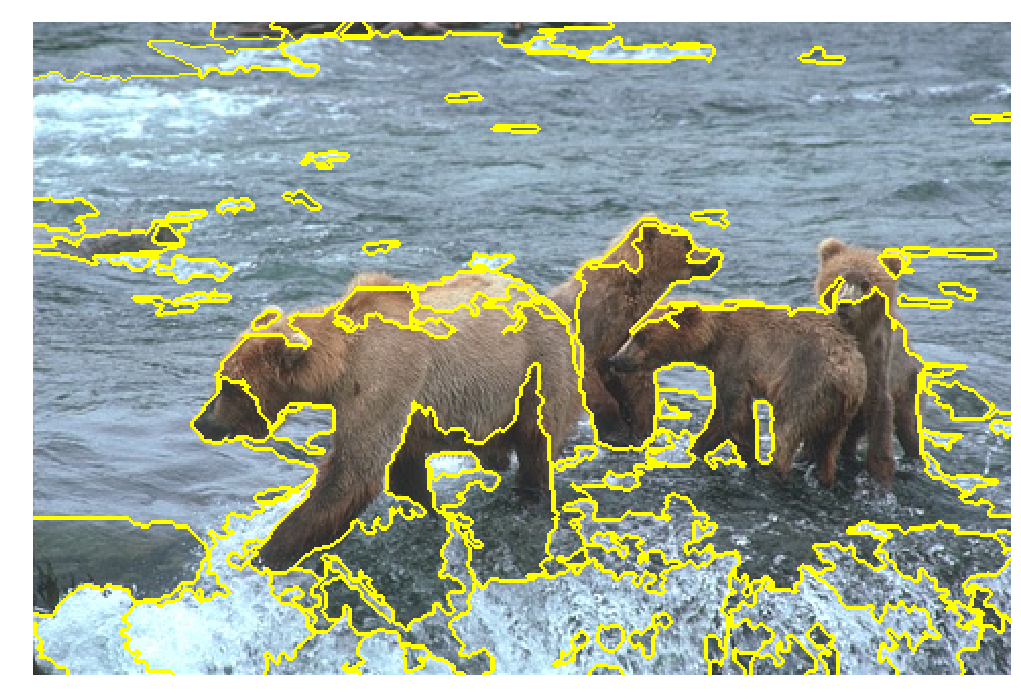

In [181]:
fig = plt.figure(figsize=(18,12))
plt.imshow(seg.mark_boundaries(imagen_rgb, segmentos_rag_felzenszwalb_normalizado))
plt.axis('off')
plt.title('Contornos RAG para Felzenszwalb con corte normalizado', color='white')
plt.show()

### Contadores de segmentos únicos segun cada algoritmo con su variante

In [198]:
print("Algoritmo K-Means (OpenCV): {}".format(np.unique(segmentos_kmeans).size))
print("Algoritmo SLIC: {}".format(np.unique(segmentos_slic).size))
print("Algoritmo Felzenszwalg: {}".format(np.unique(segmentos_felzenszwalb).size))

print("RAG SLIC con corte por umbral: {} ".format(np.unique(segmentos_rag_slic).size))
print("RAG SLIC con corte normalizado: {} ".format(np.unique(segmentos_rag_slic_normalizado).size))
print("RAG Felzenszwalb con corte por umbral: {} ".format(np.unique(segmentos_rag_felzenszwalb).size))
print("RAG Felzenszwalb con corte normalizado: {} ".format(np.unique(segmentos_rag_felzenszwalb_normalizado).size))


Algoritmo K-Means (OpenCV): 16
Algoritmo SLIC: 359
Algoritmo Felzenszwalg: 411
RAG SLIC con corte por umbral: 81 
RAG SLIC con corte normalizado: 39 
RAG Felzenszwalb con corte por umbral: 172 
RAG Felzenszwalb con corte normalizado: 94 


### Histograma de gradientes orientados

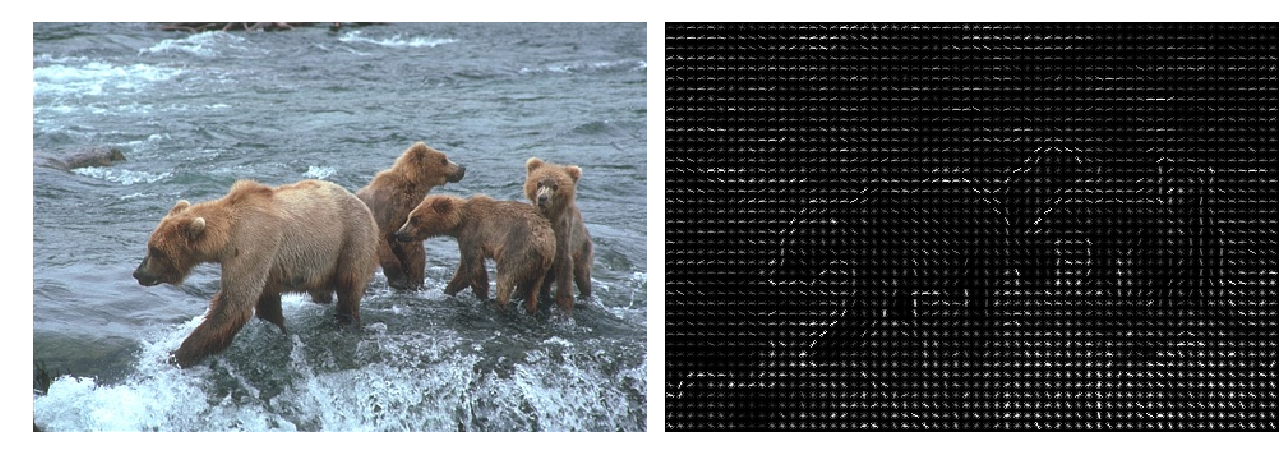

In [200]:
fd, hog_imagen = feature.hog(imagen_rgb, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(imagen_rgb, cmap=plt.cm.gray)
ax1.set_title('Imagen original', color='white')

# Se reescala el histograma para mejor visualizacicón
hog_imagen_rescalada = exposure.rescale_intensity(hog_imagen, in_range=(0, 40))

ax2.axis('off')
ax2.imshow(hog_imagen_rescalada, cmap=plt.cm.gray)
ax2.set_title('Histograma de Gradientes Orientados', color='white')
plt.tight_layout()
plt.show()



### Entropía

ValueError: The parameter `image` must be a 2-dimensional array

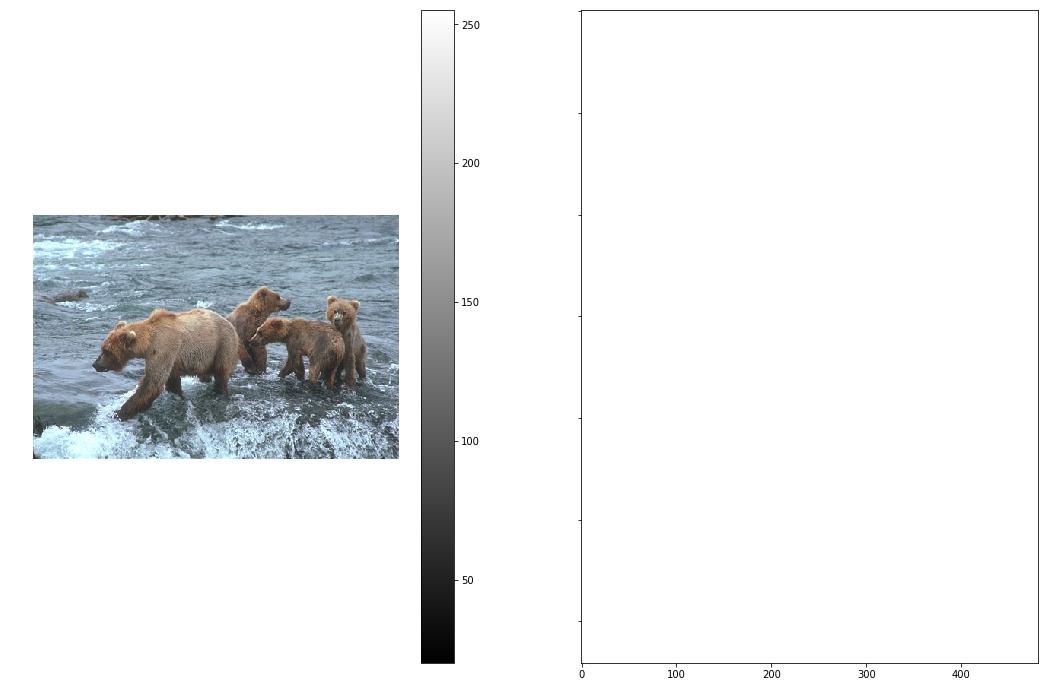

In [184]:
imagen_ubyte = util.img_as_ubyte(imagen_rgb)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 12),
                               sharex=True, sharey=True)

img0 = ax0.imshow(imagen_ubyte, cmap=plt.cm.gray)
ax0.set_title("Image", color='white')
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(filters.rank.entropy(imagen_ubyte, morph.disk(5)), cmap='gray')
ax1.set_title("Entropy", color='white')
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

plt.show()

### Etiquetado de contornos en base a segmentación realizada (Labeling)

In [297]:
colores = {
    '0': [0, 160, 160],
    '1': [10, 160, 160],
    '2': [20, 160, 160],
    '3': [30, 160, 160],
    '4': [40, 160, 160],
    '5': [50, 160, 160],
    '6': [60, 160, 160],
    '7': [70, 160, 160],
    '8': [80, 160, 160],
    '9': [90, 160, 160],
    '10': [100, 160, 160],
    '11': [110, 160, 160],
    '12': [120, 160, 160],
    '13': [130, 160, 160],
    '14': [140, 160, 160],
    '15': [150, 160, 160],
    '16': [160, 160, 160],
    '17': [170, 160, 160],
    '18': [180, 160, 160],
    '19': [0, 200, 200],
    '20': [10, 200, 200],
    '21': [20, 200, 200],
    '22': [30, 200, 200],
    '23': [40, 200, 200],
    '24': [50, 200, 200],
    '25': [60, 200, 200],
    '26': [70, 200, 200],
    '27': [80, 200, 200],
    '28': [90, 200, 200],
    '29': [100, 200, 200],
    '30': [110, 200, 200],
    '31': [120, 200, 200],
    '32': [130, 200, 200],
    '33': [140, 200, 200],
    '34': [150, 200, 200],
    '35': [160, 200, 200],
    '36': [170, 200, 200],
    '37': [180, 200, 200],
    '38': [0, 240, 240],
    '39': [10, 240, 240],
}

# Se obtienen los segmentos para graficar
segmentos = np.empty((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
flag = 1
try:
    segmentos_alcanzados = np.unique(segmentos_rag_slic_normalizado)
    for a in range(len(segmentos_rag_slic_normalizado)):
        for b in range(len(segmentos_rag_slic_normalizado[0])):
            indice = np.where(
                segmentos_alcanzados == segmentos_rag_slic_normalizado[a][b]
            )[0][0]
            segmentos[indice][a][b] = colores.get(
                str(segmentos_rag_slic_normalizado[a][b]), [150,240,240])
except Exception as e:
    print("{} error: {}".format(a,e))
    


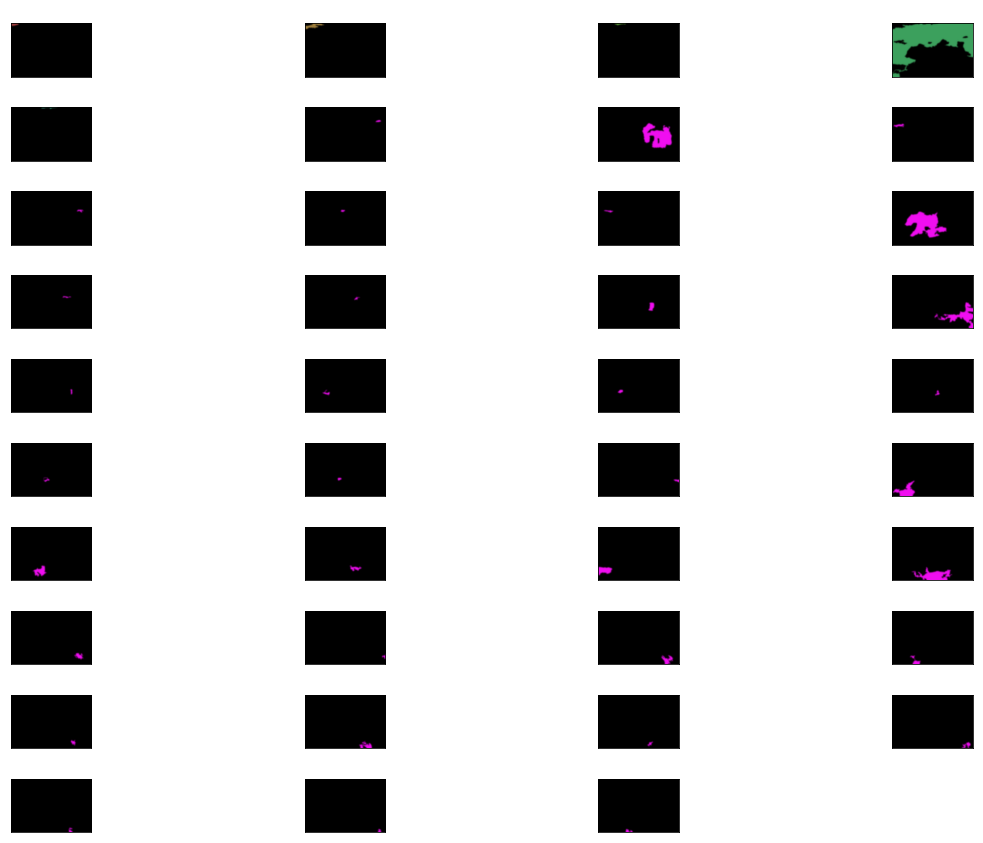

In [298]:
# Se grafican todos los segmentos
fig = plt.figure(figsize=(18,12))
imagen_segmentos = np.zeros((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
for a in range(len(segmentos)):
    imagen_segmentos[a] = cv2.cvtColor(segmentos[a], cv2.COLOR_HSV2RGB)
    plt.subplot(10,4,a+1),plt.imshow(imagen_segmentos[a], interpolation = 'bicubic')
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.title("Seg {}".format(a),color="white")
    plt.xticks([]),plt.yticks([])

plt.show()

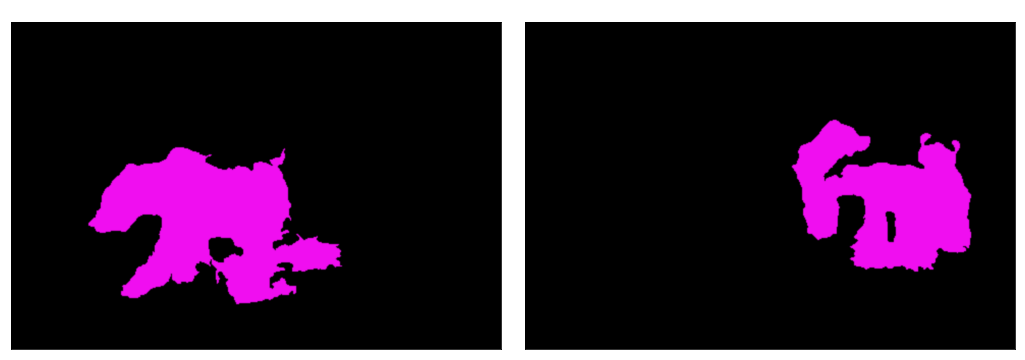

In [299]:
# Se limita a graficar los segmentos deseados (11 y 6)
fig = plt.figure(figsize=(18,12))
imagen_segmentos = np.zeros((
    np.unique(segmentos_rag_slic_normalizado).size,
    len(segmentos_rag_slic_normalizado),
    len(segmentos_rag_slic_normalizado[0]),
    3), np.uint8)
oso1 = cv2.cvtColor(segmentos[11], cv2.COLOR_HSV2RGB)
plt.subplot(1,2,1),plt.imshow(oso1, interpolation = 'bicubic')
plt.title("Oso 1",color="white")
plt.xticks([]),plt.yticks([])

oso2 = cv2.cvtColor(segmentos[6], cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso2, interpolation = 'bicubic')
plt.title("Oso 2",color="white")
plt.xticks([]),plt.yticks([])

plt.subplots_adjust(wspace=0.05)
plt.show()

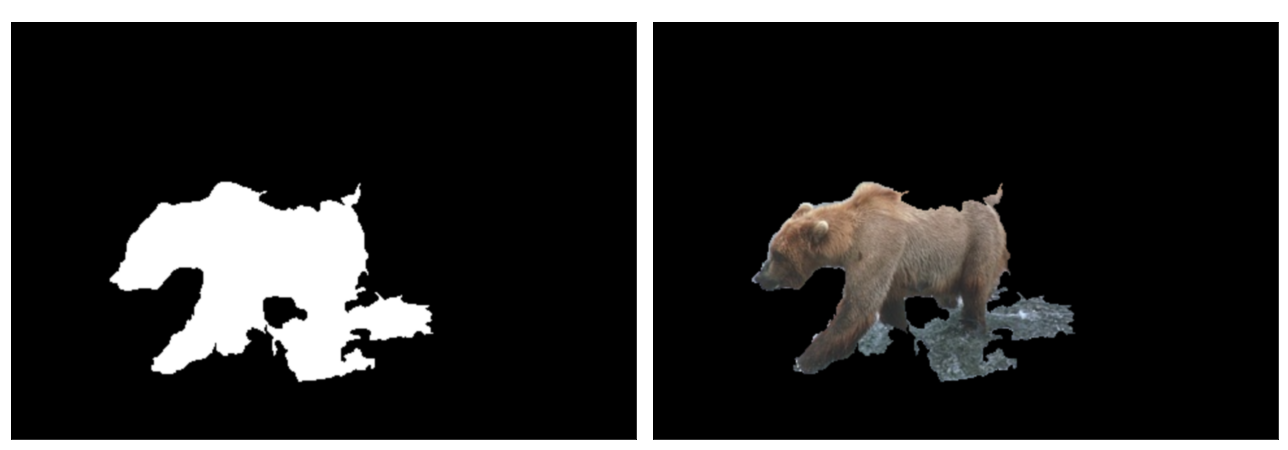

In [306]:
# Se va a graficar el oso del segmento 11

# Se aplica un threshold para convertir a escala de grises el segmento correspondiente
mascara_oso_1 = cv2.inRange(
    segmentos[11],
    np.array([50,150,150]),
    np.array([180,240,240])
)

# AND a nivel de bit para quedarme con el oso de la imagen
oso_1 = cv2.bitwise_and(imagen, imagen, mask=mascara_oso_1)

# El cv2.inRange devuelve un GRAY y no un HSV, por eso el pasaje
mascara_oso_1_rgb = cv2.cvtColor(mascara_oso_1, cv2.COLOR_GRAY2RGB)
fig = plt.figure(figsize=(18,12))

plt.subplot(1,2,1),plt.imshow(mascara_oso_1_rgb, interpolation = 'bicubic')
plt.title("Mascara Oso 1", color="white")
plt.xticks([]),plt.yticks([])

oso1_rgb = cv2.cvtColor(oso_1, cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso1_rgb, interpolation = 'bicubic')
plt.title("Oso 1",color="white")
plt.xticks([]),plt.yticks([])

plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()

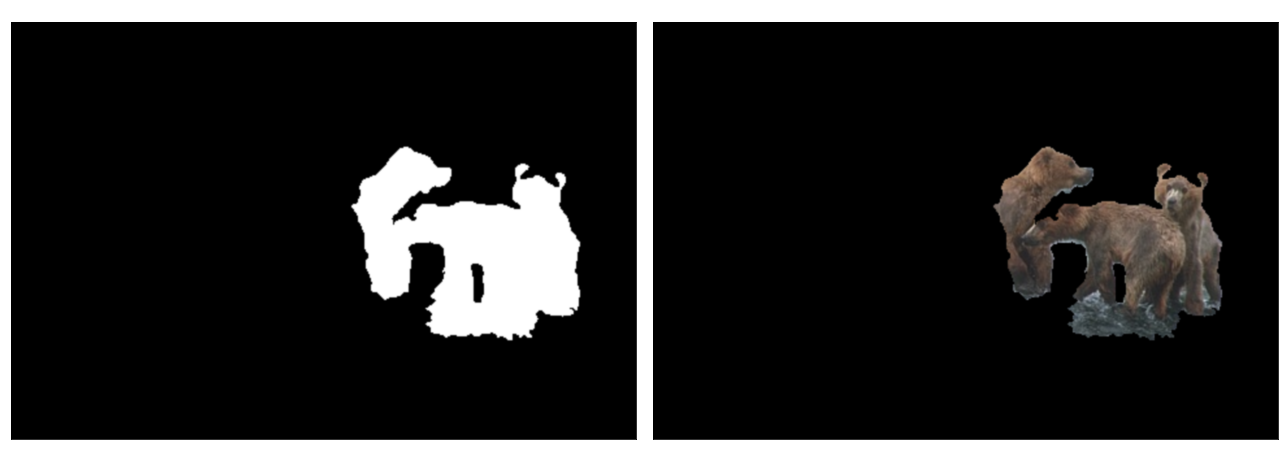

In [305]:
# Se va a graficar el oso del segmento 6

# Se aplica un threshold para convertir a escala de grises el segmento correspondiente
mascara_oso_2 = cv2.inRange(
    segmentos[6],
    np.array([50,150,150]),
    np.array([180,240,240])
)

# AND a nivel de bit para quedarme con el oso de la imagen
oso_2 = cv2.bitwise_and(imagen, imagen, mask=mascara_oso_2)

# El cv2.inRange devuelve un GRAY y no un HSV, por eso el pasaje
mascara_oso_2_rgb = cv2.cvtColor(mascara_oso_2, cv2.COLOR_GRAY2RGB)
fig = plt.figure(figsize=(18,12))

plt.subplot(1,2,1),plt.imshow(mascara_oso_2_rgb, interpolation = 'bicubic')
plt.title("Mascara Oso 2", color="white")
plt.xticks([]),plt.yticks([])

oso2_rgb = cv2.cvtColor(oso_2, cv2.COLOR_HSV2RGB)
plt.subplot(1,2,2),plt.imshow(oso2_rgb, interpolation = 'bicubic')
plt.title("Oso 2",color="white")
plt.xticks([]),plt.yticks([])
plt.subplots_adjust(wspace=0.05)
plt.tight_layout()
plt.show()